Topic:  Application of ensemble learners in Music Emotion Recognition

Author:Vinuraj Devaraj

Problem Statement: Develop a classification model to classification musically induced emotions and determine range of frequencies associated with each emotion quadrant depicted in Russell's circumplex model. The annotated dataset called MER Audio Traffic data set (Panda, P., Malheiro, R. & Paiva, R. P. (2018). “Novel audio features for music emotion recognition”. IEEE Transactions on Affective Computing) is considered for developing a classification model and deriving the fequency framework. This dataset classifies 925 sound categorized into 4 emotion quadrants viz Q1, Q2,Q3 and Q4 based on Russell's Circumplex model of emotion.  The features extracted from the each sound signal, are collated into a csv file which would act as an input to the modelling process. The rest of the document illustrates modelling approach with Adaboost as an example. Other ensemble methods considered, for which the work is still in progress, are Gradient Boosting, Hist Gradient Boosting, Random Forest and Voting Classifier 

Based on the inferences obtained during data processing and feature extraction, the MFCC features were removed from the raw dataset. In addition, the dataset was outlier treated and data augmented before deriving the final dataset for constructing the MER model. Hence the dataset selected for constructing the model is D:\PhD Program\Final Research\Sample Data\DS_1_All_Feature_5_sec_nMFCC_nht_ns_yat.csv

In [179]:
# import required libraries

# utilities
from IPython.display import Markdown as md
import librosa
import numpy as np
import random
import pandas as pd
import os

# stats
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt

# scikit - model development
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, normalize

# Classification models
from sklearn.ensemble import AdaBoostClassifier,VotingClassifier,BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import  MultiOutputClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#Clustering models
from sklearn.cluster import KMeans
from kneed import KneeLocator

#metrics
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve,auc,accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# plotting and analyzing
import seaborn as sns
import shap

# storing the model
import pickle

# User defined functions

# Convert the mel frequencies to hz using the librosa function mel_to_hz
def mel_to_hz(x):
    return round(librosa.mel_to_hz(x),2)

# Initialize common variables
num_trials = 20
seed_value = 123467

# Set file paths
root_path = "D:/PhD Program/Final Research/Dissertation/Data/Model Datasets/"
data_file_path = root_path + "DS_1_All_Feature_5_sec_nMFCC_nht_ns_yat.csv"
os.chdir(root_path)

# set random seed
random.seed(seed_value)
np.random.seed(seed_value)

In [4]:
############################## Raw Data ##########################################################
# read the dataset - based on the outcome of data processing & basic feature engineering
data_df_raw = pd.read_csv(data_file_path)

# Eliminate MFCC features for the time being
data_df_raw = data_df_raw.loc[:,~data_df_raw.columns.str.contains("mfcc_")]

# Convert the sound_file_class label into a ordinal variable 
data_df_raw['sound_file_class_num'] = data_df_raw.apply(lambda x: 1 if x.sound_file_class=='Q1' 
                                                        else (2 if x.sound_file_class=='Q2' 
                                                              else (3 if x.sound_file_class=='Q3' else 4)), axis=1)

# derive a 3 level depdendent variable - combining Q1 & Q4 into a single class and Q2 & Q3 as seperate - 
# This will create class imbalance, needs to be handled apprpriately later
data_df_raw['new_sound_file_class'] = data_df_raw.apply(lambda x: 2 if (x.sound_file_class=='Q3' or x.sound_file_class=='Q4')
                                                        else (1 if x.sound_file_class=='Q2' 
                                                              else 0), axis=1)


# derive a dichotomous variable - 0 for "Q2" and 1 for the rest
data_df_raw['new_sound_file_class_dich'] = data_df_raw.apply(lambda x: 0 if x.sound_file_class=='Q2' else 1, axis=1)

X_raw = data_df_raw[data_df_raw.columns[~data_df_raw.columns.isin(['sound_file_name', 'sound_file_class','sound_file_class_num',
                                                                   'new_sound_file_class','new_sound_file_class_dich','class_name','track id',' genre', 
                                                                   'genre_name'])]]


# Replace null values with 0
null_cols = X_raw.select_dtypes(np.number).columns
X_raw[null_cols] = X_raw[null_cols].fillna(0)
#X_raw = X_raw.fillna(0)
X_raw_orig = X_raw

# Transformed class variable (ordinal)
y,unique_vals_num = pd.factorize(data_df_raw['sound_file_class_num'], sort=True)

# Derived class variable
y_lev_3,unique_vals_new = pd.factorize(data_df_raw['new_sound_file_class'], sort=True)

# Derived class variable
y_dicht,unique_vals_dich = pd.factorize(data_df_raw['new_sound_file_class_dich'], sort=True)

# Inital class variable
y_char,unique_vals = pd.factorize(data_df_raw['sound_file_class'], sort=True)

# Seperate validation set to use only for final validation
X_train_model, X_valid, y_train_model, y_valid = train_test_split(X_raw,y,test_size=0.1,stratify=y)

# Set the parameters obtained through the feature selection process (chapter 4) as the default adaboost parameters
n_est, learn_rate = 1500, 0.1


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [122]:
X_raw.shape

(6287, 431)

In [5]:
# Base AdaBoost model with n_estimators and learning_rate as 1500 and 0.1 respectievely
# base estimator is DecisionTree with max_depth varying from 1 to 10
# Training set is static i.e. same training set is used for training the model with varying max_depth parameter for DecisionTree

max_depths = [i+1 for i in range(10)]
acc_vals = []
auc_vals = []
f1s_vals = []
acc_valid = []
auc_valid = []
f1s_valid = []
class_rpt = []
class_rpt_valid = []
X_train, X_test, y_train, y_test = train_test_split(X_train_model,y_train_model,test_size=0.3,stratify=y_train_model)
for max_depth in max_depths:
    base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1)
    ab_clf = AdaBoostClassifier(base_estimator = base_estimator,
                                n_estimators=n_est, 
                                learning_rate = learn_rate, 
                                random_state=1)
    ab_clf.fit(X_train,y_train)
    y_pred = ab_clf.predict(X_test)
    y_pred_prob = ab_clf.predict_proba(X_test)

    curr_acc_test = round(accuracy_score(y_test, y_pred),3)
    curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
    curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
    
    class_reprot = classification_report(y_test,y_pred)
    print("-------------------------------")
    print("Test report")
    print("-------------------------------")
    print(class_reprot)
    acc_vals.append(curr_acc_test)
    auc_vals.append(curr_auc)
    f1s_vals.append(curr_f1s)
    
    class_rpt.append(class_reprot)
    print("-------------------------------")
    y_pred = ab_clf.predict(X_valid)
    y_pred_prob = ab_clf.predict_proba(X_valid)
    
    curr_acc = round(accuracy_score(y_valid, y_pred),3)
    curr_auc = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
    curr_f1s = round(f1_score(y_valid,y_pred,average="weighted"),3)
    
    acc_valid.append(curr_acc)
    auc_valid.append(curr_auc)
    f1s_valid.append(curr_f1s)

    class_reprot = classification_report(y_valid,y_pred)
    print("Validation report")
    print("-------------------------------")
    print(class_reprot)
    print("-------------------------------")
    class_rpt_valid.append(class_reprot)
    print(" Test Vs Validation accuracies :" + str(curr_acc_test)+" : "+str(curr_acc))
    print("------------------------------------------------------------------------------------")

base_model_vals = {'max_depths':max_depths,
                   'acc_test':acc_vals,
                   'auc_test':auc_vals,
                   'f1s_test':f1s_vals,
                   'class_report_test':class_rpt,
                   'acc_valid':acc_valid,
                   'auc_valid':auc_valid,
                   'f1s_valid':f1s_valid,
                   'class_report_valid':class_rpt_valid}
optimal_vals_sd = pd.DataFrame(base_model_vals)
optimal_vals_sd.to_csv("optimal_vals_AB_static_train_set.csv", index=False)
print(optimal_vals_sd)

-------------------------------
Test report
-------------------------------
              precision    recall  f1-score   support

           0       0.52      0.74      0.61       423
           1       0.90      0.63      0.74       425
           2       0.57      0.47      0.51       425
           3       0.56      0.61      0.59       425

    accuracy                           0.61      1698
   macro avg       0.64      0.61      0.61      1698
weighted avg       0.64      0.61      0.61      1698

-------------------------------
Validation report
-------------------------------
              precision    recall  f1-score   support

           0       0.51      0.71      0.60       157
           1       0.88      0.67      0.76       158
           2       0.58      0.52      0.55       157
           3       0.58      0.57      0.57       157

    accuracy                           0.62       629
   macro avg       0.64      0.62      0.62       629
weighted avg       0.64    

-------------------------------
Test report
-------------------------------
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       423
           1       0.88      0.76      0.82       425
           2       0.60      0.63      0.61       425
           3       0.61      0.61      0.61       425

    accuracy                           0.68      1698
   macro avg       0.68      0.68      0.68      1698
weighted avg       0.68      0.68      0.68      1698

-------------------------------
Validation report
-------------------------------
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       157
           1       0.84      0.81      0.82       158
           2       0.58      0.63      0.60       157
           3       0.64      0.59      0.61       157

    accuracy                           0.68       629
   macro avg       0.68      0.68      0.68       629
weighted avg       0.68    

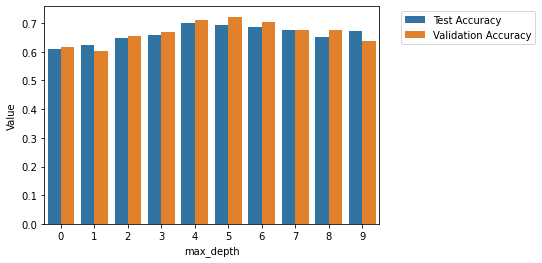

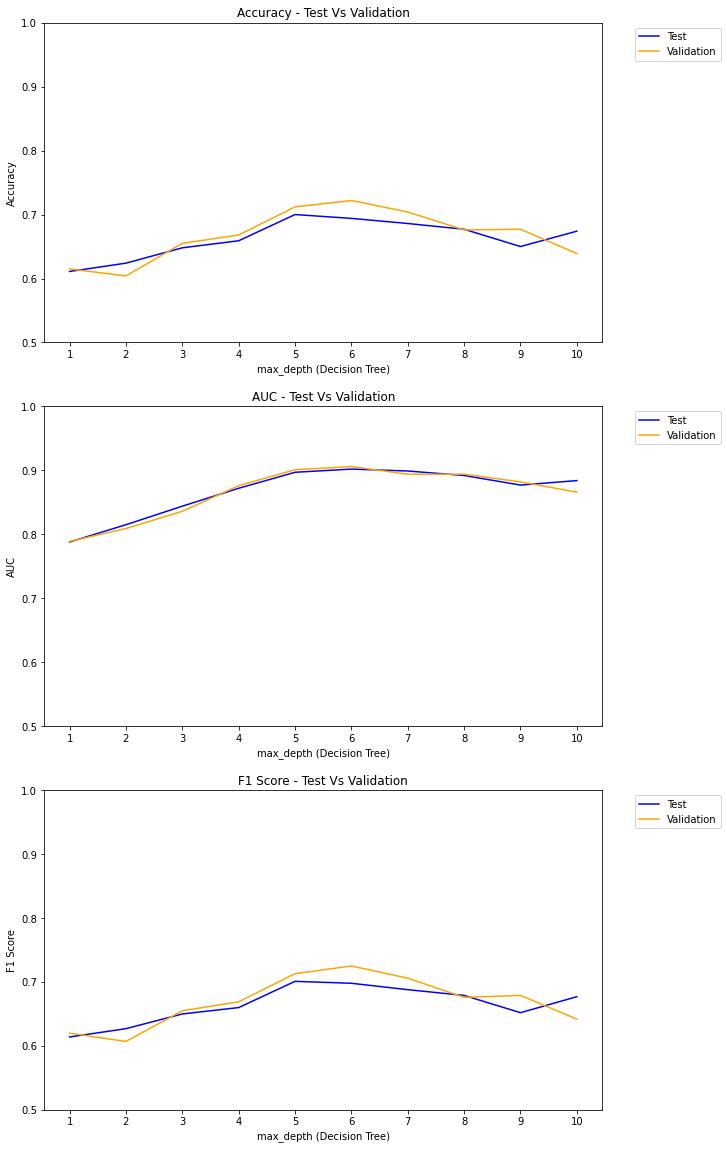

In [8]:
# plot the test and validation accuracies for each value of max_depth parameter
plot_df = pd.DataFrame({'Validation Factor':['Test Accuracy' for i in list(optimal_vals_sd.acc_test)],
                       'Value':list(optimal_vals_sd.acc_test)})
temp_df = pd.DataFrame({'Validation Factor':['Validation Accuracy' for i in list(optimal_vals_sd.acc_valid)],
                       'Value':list(optimal_vals_sd.acc_valid)})
plot_df = pd.concat([plot_df,temp_df], axis=0).reset_index()
plot_df.rename(columns={'index':'max_depth'}, inplace=True)
plot_df
# # Bar plot
sns.barplot(x='max_depth', y='Value', hue='Validation Factor', data=plot_df)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()

figure, (ax1,ax2,ax3) = plt.subplots(3,1, figsize= (10,20))

# Accuracy plot
ax1.plot(optimal_vals_sd.max_depths,optimal_vals_sd.acc_test, color = 'blue')
ax1.plot(optimal_vals_sd.max_depths,optimal_vals_sd.acc_valid, color = 'orange')
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("max_depth (Decision Tree)")
ax1.set_title("Accuracy - Test Vs Validation")
ax1.set_ylim(0.5,1)
ax1.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Test','Validation'])
plt.sca(ax1)
plt.xticks(optimal_vals_sd.max_depths, optimal_vals_sd.max_depths)

# Auc plot
ax2.plot(optimal_vals_sd.max_depths,optimal_vals_sd.auc_test, color = 'blue')
ax2.plot(optimal_vals_sd.max_depths,optimal_vals_sd.auc_valid, color = 'orange')
ax2.set_ylabel("AUC")
ax2.set_xlabel("max_depth (Decision Tree)")
ax2.set_title("AUC - Test Vs Validation")
ax2.set_ylim(0.5,1)
ax2.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Test','Validation'])
plt.sca(ax2)
plt.xticks(optimal_vals_sd.max_depths, optimal_vals_sd.max_depths)

# F1 Score plot
ax3.plot(optimal_vals_sd.max_depths,optimal_vals_sd.f1s_test, color = 'blue')
ax3.plot(optimal_vals_sd.max_depths,optimal_vals_sd.f1s_valid, color = 'orange')
ax3.set_ylabel("F1 Score")
ax3.set_xlabel("max_depth (Decision Tree)")
ax3.set_title("F1 Score - Test Vs Validation")
ax3.set_ylim(0.5,1)
ax3.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Test','Validation'])
plt.sca(ax3)
plt.xticks(optimal_vals_sd.max_depths, optimal_vals_sd.max_depths)
plt.show()
plt.show()

Till this point we have determined that AdaBoost with following parameters offers best results:
a) base estimator = Decision Tree Classifier with max_depth = 6
b) n_estimators = 1500
c) learning_rate = 0.1

The aforementioned parameters were obtained on a static train, test and validation datasets. The attempt now is to check the robustnes of the model by running 50 trials with each trial drawing a stratified random sample from the training dataset and validating the model against a static validation dataset.

In [9]:
# Base AdaBoost model with n_estimators and learning_rate as 1500 and 0.1 respectievely
# base estimator is DecisionTree with max_depth = 6
# Training set is dynamic i.e. random training set draw from the X_train_model dataset 
# validation dataset is static

num_trials = [i+1 for i in range(50)]
max_depth = 6
acc_vals = []
auc_vals = []
f1s_vals = []
acc_valid = []
auc_valid = []
f1s_valid = []
class_rpt = []
class_rpt_valid = []

base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1)
    
for trial_num in num_trials:
    X_train, X_test, y_train, y_test = train_test_split(X_train_model,y_train_model,test_size=0.2,stratify=y_train_model)    
    ab_clf = AdaBoostClassifier(base_estimator = base_estimator,
                                n_estimators=n_est, 
                                learning_rate = learn_rate, 
                                random_state=1)
    ab_clf.fit(X_train,y_train)
    y_pred = ab_clf.predict(X_test)
    y_pred_prob = ab_clf.predict_proba(X_test)

    curr_acc_test = round(accuracy_score(y_test, y_pred),3)
    curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
    curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)
    
    class_reprot = classification_report(y_test,y_pred)
#     print("-------------------------------")
#     print("Test report : Trial - "+ str(trial_num))
#     print("-------------------------------")
#     print(class_reprot)
    acc_vals.append(curr_acc_test)
    auc_vals.append(curr_auc)
    f1s_vals.append(curr_f1s)
    
    class_rpt.append(class_reprot)
    #print("-------------------------------")
    y_pred = ab_clf.predict(X_valid)
    y_pred_prob = ab_clf.predict_proba(X_valid)
    
    curr_acc = round(accuracy_score(y_valid, y_pred),3)
    curr_auc = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
    curr_f1s = round(f1_score(y_valid,y_pred,average="weighted"),3)
    
    acc_valid.append(curr_acc)
    auc_valid.append(curr_auc)
    f1s_valid.append(curr_f1s)

    class_reprot = classification_report(y_valid,y_pred)
#     print("Validation report: Trial - "+ str(trial_num))
#     print("-------------------------------")
#     print(class_reprot)
#     print("-------------------------------")
    class_rpt_valid.append(class_reprot)
    print(" Test Vs Validation accuracies : Trial - " +str(trial_num)+": " + str(curr_acc_test)+" : "+str(curr_acc))
    #print("------------------------------------------------------------------------------------")

robust_model_vals = {'num_trials':num_trials,
                   'acc_test':acc_vals,
                   'auc_test':auc_vals,
                   'f1s_test':f1s_vals,
                   'class_report_test':class_rpt,
                   'acc_valid':acc_valid,
                   'auc_valid':auc_valid,
                   'f1s_valid':f1s_valid,
                   'class_report_valid':class_rpt_valid}
optimal_vals_sd = pd.DataFrame(robust_model_vals)
optimal_vals_sd.to_csv("optimal_vals_AB_random_train_set.csv", index=False)
print(optimal_vals_sd)

 Test Vs Validation accuracies : Trial - 1: 0.687 : 0.72
 Test Vs Validation accuracies : Trial - 2: 0.746 : 0.725
 Test Vs Validation accuracies : Trial - 3: 0.74 : 0.693
 Test Vs Validation accuracies : Trial - 4: 0.693 : 0.707
 Test Vs Validation accuracies : Trial - 5: 0.717 : 0.725
 Test Vs Validation accuracies : Trial - 6: 0.703 : 0.704
 Test Vs Validation accuracies : Trial - 7: 0.701 : 0.695
 Test Vs Validation accuracies : Trial - 8: 0.718 : 0.725
 Test Vs Validation accuracies : Trial - 9: 0.719 : 0.712
 Test Vs Validation accuracies : Trial - 10: 0.708 : 0.722
 Test Vs Validation accuracies : Trial - 11: 0.718 : 0.711
 Test Vs Validation accuracies : Trial - 12: 0.711 : 0.723
 Test Vs Validation accuracies : Trial - 13: 0.68 : 0.704
 Test Vs Validation accuracies : Trial - 14: 0.676 : 0.723
 Test Vs Validation accuracies : Trial - 15: 0.718 : 0.72
 Test Vs Validation accuracies : Trial - 16: 0.699 : 0.709
 Test Vs Validation accuracies : Trial - 17: 0.694 : 0.712
 Test Vs V

0.71 0.03 0.77 0.65
0.91 0.01 0.93 0.89


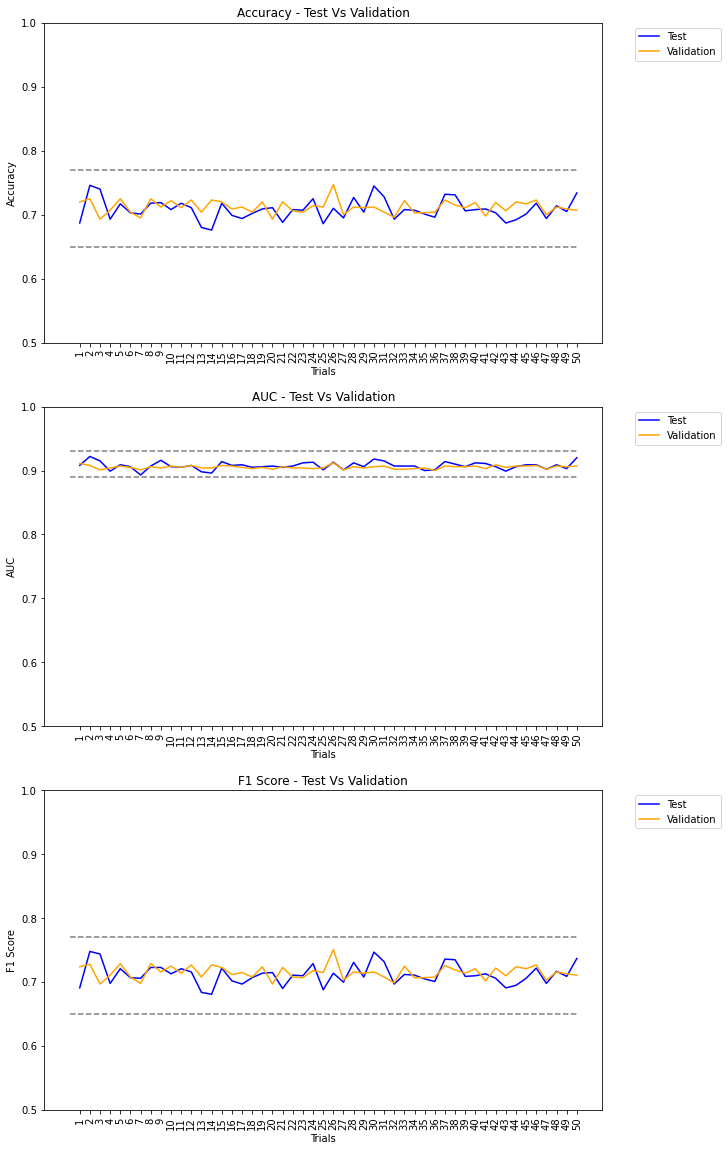

0.71 0.03 0.77 0.65


In [123]:
# plot the test and validation accuracies for each trial 
# Expectation: The accuraies should remain stable without significant deviation - stay within confidance interval +/- 1.96*sd

figure, (ax1,ax2,ax3) = plt.subplots(3,1, figsize= (10,20))
# Accuracy plot
ax1.plot(optimal_vals_sd.num_trials,optimal_vals_sd.acc_test, color = 'blue')
ax1.plot(optimal_vals_sd.num_trials,optimal_vals_sd.acc_valid, color = 'orange')
ax1.set_ylabel("Accuracy")
ax1.set_xlabel("Trials")
ax1.set_title("Accuracy - Test Vs Validation")
ax1.set_ylim(0.5,1)
ax1.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Test','Validation'])
mean_val = round(np.mean(optimal_vals_sd.acc_test),2)
sd_val = round(1.96*np.std(optimal_vals_sd.acc_test),2)
ub_val = round(mean_val + (1.96*sd_val),2)
lb_val = round(mean_val - (1.96*sd_val),2)
ax1.hlines(ub_val, 0, len(optimal_vals_sd.num_trials), linestyles="--", colors = 'gray')
ax1.hlines(lb_val, 0, len(optimal_vals_sd.num_trials), linestyles="--", colors = 'gray')
plt.sca(ax1)
plt.xticks(optimal_vals_sd.num_trials, optimal_vals_sd.num_trials, rotation=90)

print(mean_val,sd_val,ub_val,lb_val)
# # Auc plot
ax2.plot(optimal_vals_sd.num_trials,optimal_vals_sd.auc_test, color = 'blue')
ax2.plot(optimal_vals_sd.num_trials,optimal_vals_sd.auc_valid, color = 'orange')
ax2.set_ylabel("AUC")
ax2.set_xlabel("Trials")
ax2.set_title("AUC - Test Vs Validation")
ax2.set_ylim(0.5,1)
ax2.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Test','Validation'])
mean_val = round(np.mean(optimal_vals_sd.auc_test),2)
sd_val = round(1.96*np.std(optimal_vals_sd.auc_test),2)
ub_val = round(mean_val + (1.96*sd_val),2)
lb_val = round(mean_val - (1.96*sd_val),2)
ax2.hlines(ub_val, 0, len(optimal_vals_sd.num_trials), linestyles="--", colors = 'gray')
ax2.hlines(lb_val, 0, len(optimal_vals_sd.num_trials), linestyles="--", colors = 'gray')

plt.sca(ax2)
plt.xticks(optimal_vals_sd.num_trials, optimal_vals_sd.num_trials, rotation=90)
print(mean_val,sd_val,ub_val,lb_val)

# # F1 Score plot
ax3.plot(optimal_vals_sd.num_trials,optimal_vals_sd.f1s_test, color = 'blue')
ax3.plot(optimal_vals_sd.num_trials,optimal_vals_sd.f1s_valid, color = 'orange')
ax3.set_ylabel("F1 Score")
ax3.set_xlabel("Trials")
ax3.set_title("F1 Score - Test Vs Validation")
ax3.set_ylim(0.5,1)
ax3.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Test','Validation'])
mean_val = round(np.mean(optimal_vals_sd.f1s_test),2)
sd_val = round(1.96*np.std(optimal_vals_sd.f1s_test),2)
ub_val = round(mean_val + (1.96*sd_val),2)
lb_val = round(mean_val - (1.96*sd_val),2)
ax3.hlines(ub_val, 0, len(optimal_vals_sd.num_trials), linestyles="--", colors = 'gray')
ax3.hlines(lb_val, 0, len(optimal_vals_sd.num_trials), linestyles="--", colors = 'gray')

plt.sca(ax3)
plt.xticks(optimal_vals_sd.num_trials, optimal_vals_sd.num_trials, rotation=90)
plt.show()
print(mean_val,sd_val,ub_val,lb_val)

We now know that AdaBoost with following parameters offers best results: a) base estimator = Decision Tree Classifier with max_depth = 6 b) n_estimators = 1500 c) learning_rate = 0.1 and is robust (refer to plots above).

Now lets evaluate whether there's any difference in using SAMME or SAMME.R algorithm with the aforementioned paramteres

In [35]:
# Base AdaBoost model with n_estimators and learning_rate as 1500 and 0.1 respectievely
# base estimator is DecisionTree with max_depth = 6
# Training set is dynamic i.e. a single random training set drawn from the X_train_model dataset 
# validation dataset is static
# algorithm is SAMME.R
max_depth = 6
base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X_train_model,y_train_model,test_size=0.2,stratify=y_train_model)
ab_clf = AdaBoostClassifier(base_estimator = base_estimator,
                            n_estimators=n_est, 
                            learning_rate = learn_rate, 
                            random_state=1, 
                            algorithm="SAMME.R")
ab_clf.fit(X_train,y_train)
y_pred = ab_clf.predict(X_test)
y_pred_prob = ab_clf.predict_proba(X_test)

curr_acc = round(accuracy_score(y_test, y_pred),3)
curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)

class_reprot = classification_report(y_test,y_pred)
print("-------------------------------")
print("Test report : SAMME.R ")
print("-------------------------------")
print(class_reprot)

class_rpt.append(class_reprot)
#print("-------------------------------")
y_pred = ab_clf.predict(X_valid)
y_pred_prob = ab_clf.predict_proba(X_valid)

curr_acc_valid = round(accuracy_score(y_valid, y_pred),3)
curr_auc_valid = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
curr_f1s_valid = round(f1_score(y_valid,y_pred,average="weighted"),3)

class_reprot = classification_report(y_valid,y_pred)
print("Validation report: SAMME.R")
print("-------------------------------")
print(class_reprot)
print("-------------------------------")
print(" Test Vs Validation accuracies : " + str(curr_acc)+" : "+str(curr_acc_valid))
print(" Test Vs Validation AUC : " + str(curr_auc)+" : "+str(curr_auc_valid))
print(" Test Vs Validation F1 Score : " + str(curr_f1s)+" : "+str(curr_f1s_valid))

-------------------------------
Test report : SAMME.R 
-------------------------------
              precision    recall  f1-score   support

           0       0.58      0.78      0.66       282
           1       0.95      0.69      0.80       284
           2       0.66      0.64      0.65       283
           3       0.70      0.66      0.68       283

    accuracy                           0.69      1132
   macro avg       0.72      0.69      0.70      1132
weighted avg       0.72      0.69      0.70      1132

Validation report: SAMME.R
-------------------------------
              precision    recall  f1-score   support

           0       0.60      0.81      0.69       157
           1       0.94      0.73      0.83       158
           2       0.70      0.67      0.69       157
           3       0.74      0.68      0.70       157

    accuracy                           0.72       629
   macro avg       0.75      0.72      0.73       629
weighted avg       0.75      0.72      

In [5]:
# Final Modelling - refresh the datasets, just to be safe
############################## Raw Data ##########################################################
# read the dataset - based on the outcome of data processing & basic feature engineering
data_df_raw = pd.read_csv(data_file_path)

# Eliminate MFCC features for the time being
data_df_raw = data_df_raw.loc[:,~data_df_raw.columns.str.contains("mfcc_")]

# Convert the sound_file_class label into a ordinal variable 
data_df_raw['sound_file_class_num'] = data_df_raw.apply(lambda x: 1 if x.sound_file_class=='Q1' 
                                                        else (2 if x.sound_file_class=='Q2' 
                                                              else (3 if x.sound_file_class=='Q3' else 4)), axis=1)

# derive a 3 level depdendent variable - combining Q1 & Q4 into a single class and Q2 & Q3 as seperate - 
# This will create class imbalance, needs to be handled apprpriately later
data_df_raw['new_sound_file_class'] = data_df_raw.apply(lambda x: 2 if (x.sound_file_class=='Q3' or x.sound_file_class=='Q4')
                                                        else (1 if x.sound_file_class=='Q2' 
                                                              else 0), axis=1)


# derive a dichotomous variable - 0 for "Q2" and 1 for the rest
data_df_raw['new_sound_file_class_dich'] = data_df_raw.apply(lambda x: 0 if x.sound_file_class=='Q2' else 1, axis=1)

X_raw = data_df_raw[data_df_raw.columns[~data_df_raw.columns.isin(['sound_file_name', 'sound_file_class','sound_file_class_num',
                                                                   'new_sound_file_class','new_sound_file_class_dich','class_name','track id',' genre', 
                                                                   'genre_name'])]]


# Replace null values with 0
null_cols = X_raw.select_dtypes(np.number).columns
X_raw[null_cols] = X_raw[null_cols].fillna(0)
#X_raw = X_raw.fillna(0)
X_raw_orig = X_raw

# Transformed class variable (ordinal)
y,unique_vals_num = pd.factorize(data_df_raw['sound_file_class_num'], sort=True)

# Derived class variable
y_lev_3,unique_vals_new = pd.factorize(data_df_raw['new_sound_file_class'], sort=True)

# Derived class variable
y_dicht,unique_vals_dich = pd.factorize(data_df_raw['new_sound_file_class_dich'], sort=True)

# Inital class variable
y_char,unique_vals = pd.factorize(data_df_raw['sound_file_class'], sort=True)

# Seperate validation set to use only for final validation
X_train_model, X_valid, y_train_model, y_valid = train_test_split(X_raw,y,test_size=0.1,stratify=y)

# Set the parameters obtained through the feature selection process (chapter 4) as the default adaboost parameters
n_est, learn_rate, max_depth = 1500, 0.1, 6
base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# Base AdaBoost model with n_estimators and learning_rate as 1500 and 0.1 respectievely
# base estimator is DecisionTree with max_depth = 6
# Training set is dynamic i.e. single random training set drawn from the X_train_model dataset 
# validation dataset is static
# algorithm is SAMME

X_train, X_test, y_train, y_test = train_test_split(X_train_model,y_train_model,test_size=0.2,stratify=y_train_model)
ab_clf = AdaBoostClassifier(base_estimator = base_estimator,
                            n_estimators=n_est, 
                            learning_rate = learn_rate, 
                            random_state=1, 
                            algorithm="SAMME")
ab_clf.fit(X_train,y_train)
y_pred = ab_clf.predict(X_test)
y_pred_prob = ab_clf.predict_proba(X_test)

curr_acc = round(accuracy_score(y_test, y_pred),3)
curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)

class_reprot = classification_report(y_test,y_pred)
print("-------------------------------")
print("Test report : Final Modelling - all features ")
print("-------------------------------")
print(class_reprot)

#print("-------------------------------")
y_pred = ab_clf.predict(X_valid)
y_pred_prob = ab_clf.predict_proba(X_valid)

curr_acc_valid = round(accuracy_score(y_valid, y_pred),3)
curr_auc_valid = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
curr_f1s_valid = round(f1_score(y_valid,y_pred,average="weighted"),3)

class_reprot = classification_report(y_valid,y_pred)
print("Validation report: Final Modelling - all features")
print("-------------------------------")
print(class_reprot)
print("-------------------------------")
print(" Test Vs Validation accuracies : " + str(curr_acc)+" : "+str(curr_acc_valid))
print(" Test Vs Validation AUC : " + str(curr_auc)+" : "+str(curr_auc_valid))
print(" Test Vs Validation F1 Score : " + str(curr_f1s)+" : "+str(curr_f1s_valid))

-------------------------------
Test report : Final Modelling - all features 
-------------------------------
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       282
           1       0.94      0.86      0.90       283
           2       0.74      0.73      0.73       283
           3       0.77      0.71      0.74       284

    accuracy                           0.78      1132
   macro avg       0.79      0.78      0.79      1132
weighted avg       0.79      0.78      0.79      1132

Validation report: Final Modelling - all features
-------------------------------
              precision    recall  f1-score   support

           0       0.67      0.80      0.73       157
           1       0.94      0.83      0.88       158
           2       0.73      0.71      0.72       157
           3       0.79      0.75      0.77       157

    accuracy                           0.77       629
   macro avg       0.78      0.77      0.78    

We now know that AdaBoost with following parameters offers best results: 
a) base estimator = Decision Tree Classifier with max_depth = 6 
b) n_estimators = 1500 
c) learning_rate = 0.1 
d) Multiclass boosting algorithm = SAMME

Now lets optimize the algorithm to look at getting reduced number of features by evaluating feature importances.

In [16]:
print(ab_clf)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=6,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=1500, random_state=1)


In [8]:
# Get Feature importances
feat_imp = ab_clf.feature_importances_
col_names = X_train.columns
feat_imp_df = pd.DataFrame({"feature_names": list(col_names),
                          'feature_imp':list(feat_imp)})
feat_imp_df.sort_values(by='feature_imp', ascending=False, inplace=True)
print(feat_imp_df)


             feature_names  feature_imp
7    spect_centroid_median     0.094552
430          loudness_mean     0.028755
12      spect_rolloff_mean     0.019007
0                  f0_mean     0.017903
389          mel_57_median     0.015347
..                     ...          ...
331             mel_47_min     0.000385
169             mel_20_min     0.000368
319             mel_45_min     0.000363
306             mel_43_max     0.000301
271             mel_37_min     0.000234

[431 rows x 2 columns]


In [131]:
feat_imp_df.shape

(431, 2)

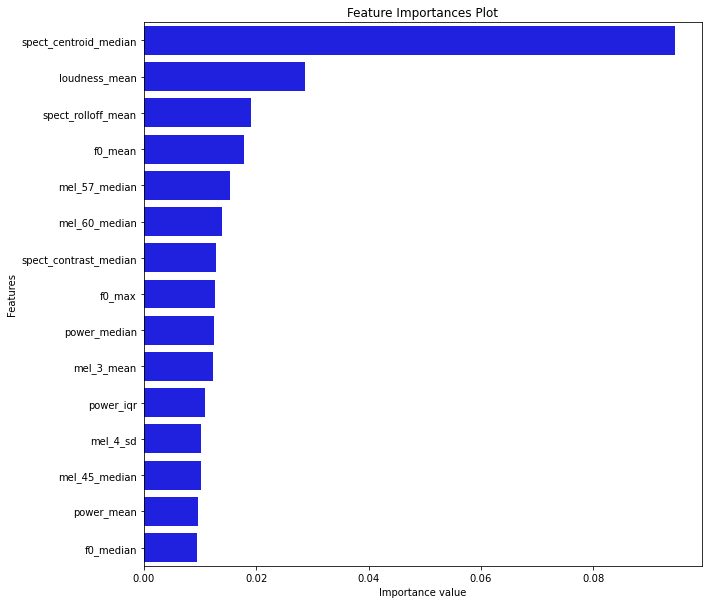

In [24]:
plt.figure(figsize=(10,10))
sns.barplot(y='feature_names', x='feature_imp', data=feat_imp_df.iloc[:15,:], color='blue')
plt.title("Feature Importances Plot")
plt.ylabel("Features")
plt.xlabel("Importance value")
plt.show()

In [42]:
# Optimizing the model - IMP: Long running code: Careful before executing

# select all features by feature importance
all_features = list(feat_imp_df.feature_names)
all_feat_acc_test = []
all_feat_auc_test = []
all_feat_f1s_test = []

all_feat_acc_valid = []
all_feat_auc_valid = []
all_feat_f1s_valid = []

num_feat = []
start_point = 0
feat_end_point = 0
feature_set = []

max_depth = 6
base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1)
ab_clf = AdaBoostClassifier(base_estimator = base_estimator,
                            n_estimators=n_est, 
                            learning_rate = learn_rate, 
                            random_state=1, 
                            algorithm="SAMME")

X_train, X_test, y_train, y_test = train_test_split(X_train_model,y_train_model,test_size=0.2,stratify=y_train_model)

for end_point in range(5,len(all_features),5):
    top_n_cols = list(all_features[start_point:end_point])
    num_feat.append(len(top_n_cols))
    feature_set.append(top_n_cols)
    
    X_train_n_cols = X_train[top_n_cols]
    ab_clf.fit(X_train_n_cols,y_train)
    y_pred = ab_clf.predict(X_test[top_n_cols])
    y_pred_prob = ab_clf.predict_proba(X_test[top_n_cols])

    curr_acc = round(accuracy_score(y_test, y_pred),3)
    curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
    curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)

    all_feat_acc_test.append(curr_acc)
    all_feat_auc_test.append(curr_auc)
    all_feat_f1s_test.append(curr_f1s)
    
    y_pred = ab_clf.predict(X_valid[top_n_cols])
    y_pred_prob = ab_clf.predict_proba(X_valid[top_n_cols])

    curr_acc = round(accuracy_score(y_valid, y_pred),3)
    curr_auc = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
    curr_f1s = round(f1_score(y_valid,y_pred,average="weighted"),3)

    all_feat_acc_valid.append(curr_acc)
    all_feat_auc_valid.append(curr_auc)
    all_feat_f1s_valid.append(curr_f1s)
    
        
all_feat_optimal_vals = {'num_feat':num_feat,
                         'acc_test':all_feat_acc_test,
                         'auc_test':all_feat_auc_test,
                         'f1s_test':all_feat_f1s_test,
                         'acc_valid':all_feat_acc_valid,
                         'auc_valid':all_feat_auc_valid,
                         'f1s_valid':all_feat_f1s_valid,
                         'feature_set':feature_set}
all_feat_optimal_df = pd.DataFrame(all_feat_optimal_vals)
all_feat_optimal_df

,num_feat,acc_test,auc_test,f1s_test,acc_valid,auc_valid,f1s_valid,feature_set
0,5,0.707,0.873,0.709,0.730,0.875,0.730,"[spect_centroid_median, loudness_mean, spect_r..."
1,10,0.698,0.871,0.698,0.733,0.872,0.734,"[spect_centroid_median, loudness_mean, spect_r..."
2,15,0.707,0.887,0.708,0.731,0.885,0.732,"[spect_centroid_median, loudness_mean, spect_r..."
3,20,0.743,0.903,0.744,0.765,0.895,0.766,"[spect_centroid_median, loudness_mean, spect_r..."
4,25,0.741,0.906,0.743,0.742,0.897,0.743,"[spect_centroid_median, loudness_mean, spect_r..."
...,...,...,...,...,...,...,...,...
81,410,0.777,0.916,0.779,0.773,0.905,0.774,"[spect_centroid_median, loudness_mean, spect_r..."
82,415,0.778,0.915,0.780,0.765,0.902,0.766,"[spect_centroid_median, loudness_mean, spect_r..."
83,420,0.774,0.913,0.775,0.769,0.900,0.771,"[spect_centroid_median, loudness_mean, spect_r..."
84,425,0.774,0.914,0.776,0.768,0.904,0.769,"[spect_centroid_median, loudness_mean, spect_r..."


0     0.293
1     0.302
2     0.293
3     0.257
4     0.259
      ...  
81    0.223
82    0.222
83    0.226
84    0.226
85    0.218
Name: acc_test, Length: 86, dtype: float64

    num_feat  acc_test  auc_test  f1s_test  acc_valid  auc_valid  f1s_valid  \
17        90     0.787      0.92     0.788      0.795      0.912      0.797   

                                          feature_set  
17  [spect_centroid_median, loudness_mean, spect_r...  
90


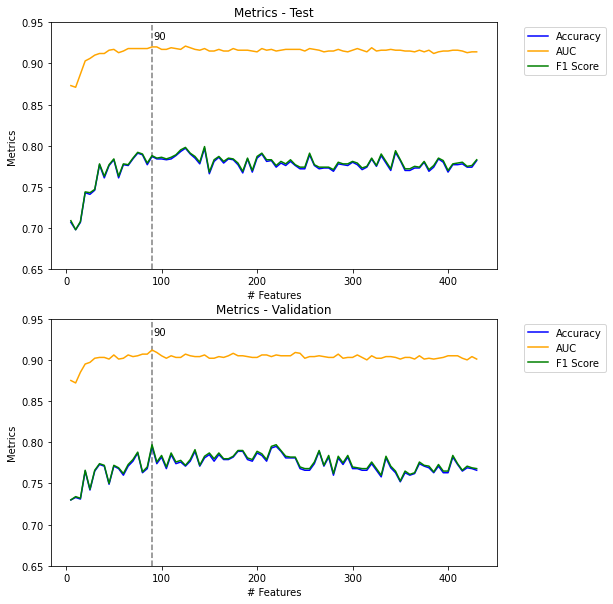

In [100]:
# choose cut off point
print(all_feat_optimal_df[all_feat_optimal_df.auc_valid==max(all_feat_optimal_df.auc_valid[0:100])])
num_feat_val = int(all_feat_optimal_df[all_feat_optimal_df.auc_valid==max(all_feat_optimal_df.auc_valid[0:100])]['num_feat'])
print(num_feat_val)

figure, (ax1,ax2) = plt.subplots(2,1, figsize= (8,10))
# Test Metrics plot
ax1.plot(all_feat_optimal_df.num_feat,all_feat_optimal_df.acc_test, color = 'blue')
ax1.plot(all_feat_optimal_df.num_feat,all_feat_optimal_df.auc_test, color  = 'orange')
ax1.plot(all_feat_optimal_df.num_feat,all_feat_optimal_df.f1s_test, color  = 'green')
ax1.set_ylabel("Metrics")
ax1.set_xlabel("# Features")
ax1.set_title("Metrics - Test")
ax1.set_ylim(0.65,0.95)
ax1.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Accuracy','AUC','F1 Score'])
ax1.vlines(num_feat_val, 0.65, 0.95, linestyles="--", colors = 'gray')
ax1.annotate(str(num_feat_val),(num_feat_val+1, 0.93))
plt.sca(ax1)
#plt.xticks(all_feat_optimal_df.num_feat, all_feat_optimal_df.num_feat, rotation=90)

# Validation Metrics plot
ax2.plot(all_feat_optimal_df.num_feat,all_feat_optimal_df.acc_valid, color = 'blue')
ax2.plot(all_feat_optimal_df.num_feat,all_feat_optimal_df.auc_valid, color  = 'orange')
ax2.plot(all_feat_optimal_df.num_feat,all_feat_optimal_df.f1s_valid, color  = 'green')
ax2.set_ylabel("Metrics")
ax2.set_xlabel("# Features")
ax2.set_title("Metrics - Validation")
ax2.set_ylim(0.65,0.95)
ax2.legend(bbox_to_anchor=(1.05,1), loc="upper left", labels=['Accuracy','AUC','F1 Score'])
ax2.annotate(str(num_feat_val),(num_feat_val+1, 0.93))
plt.sca(ax1)
#plt.xticks(all_feat_optimal_df.num_feat, all_feat_optimal_df.num_feat, rotation=90)

ax2.vlines(num_feat_val, 0.65, 0.95, linestyles="--", colors = 'gray')

plt.show()



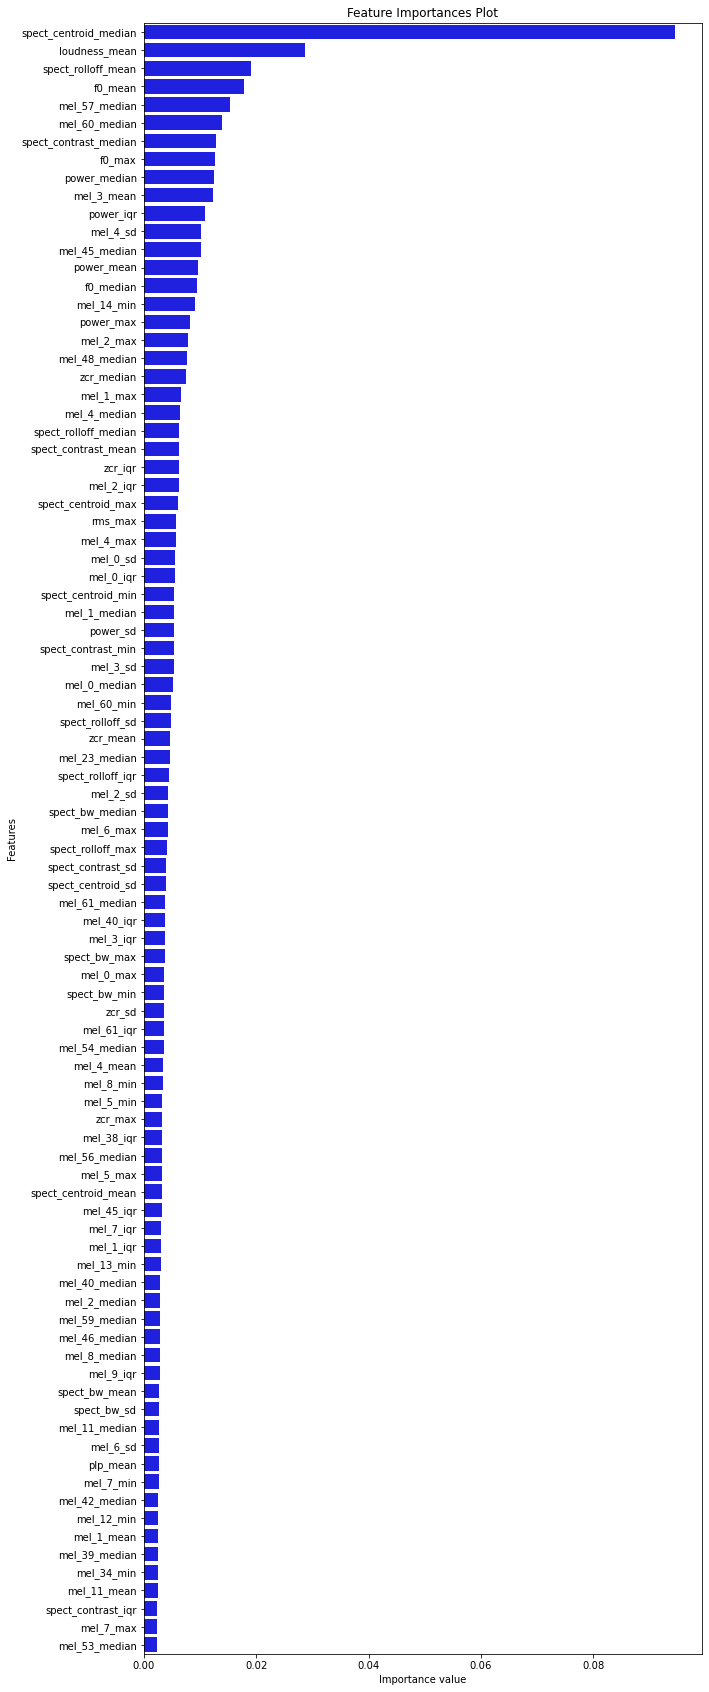

In [123]:
top_n_cols = all_feat_optimal_df[all_feat_optimal_df.auc_valid==max(all_feat_optimal_df.auc_valid[0:100])]['feature_set']
#print(list(top_n_cols)[0])
plt.figure(figsize=(10,30))
#sns.barplot(y='feature_names', x='feature_imp', data=feat_imp_df.iloc[:15,:], color='blue')
sns.barplot(y='feature_names', x='feature_imp', data=feat_imp_df[feat_imp_df.feature_names.isin(list(top_n_cols)[0])], 
            color='blue')
plt.title("Feature Importances Plot")
plt.ylabel("Features")
plt.xlabel("Importance value")
plt.show()

In [130]:
# Optimizing the inital model
# top_n_cols - initialized by previous cell
max_depth = 6

X_train_n_cols = X_train_model[list(top_n_cols)[0]]

base_estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X_train_n_cols,y_train_model,test_size=0.2,stratify=y_train_model)
ab_clf = AdaBoostClassifier(base_estimator = base_estimator,
                            n_estimators=n_est, 
                            learning_rate = learn_rate, 
                            random_state=1, 
                            algorithm="SAMME")
ab_clf.fit(X_train,y_train)
y_pred = ab_clf.predict(X_test)
y_pred_prob = ab_clf.predict_proba(X_test)

curr_acc = round(accuracy_score(y_test, y_pred),3)
curr_auc = round(roc_auc_score(y_test, y_pred_prob, multi_class='ovr'),3)
curr_f1s = round(f1_score(y_test,y_pred,average="weighted"),3)

class_reprot = classification_report(y_test,y_pred)
print("-------------------------------")
print("Test report : SAMME ")
print("-------------------------------")
print(class_reprot)

#print("-------------------------------")
y_pred = ab_clf.predict(X_valid[list(top_n_cols)[0]])
y_pred_prob = ab_clf.predict_proba(X_valid[list(top_n_cols)[0]])

curr_acc_valid = round(accuracy_score(y_valid, y_pred),3)
curr_auc_valid = round(roc_auc_score(y_valid, y_pred_prob, multi_class='ovr'),3)
curr_f1s_valid = round(f1_score(y_valid,y_pred,average="weighted"),3)

class_reprot = classification_report(y_valid,y_pred)
print("Validation report: SAMME")
print("-------------------------------")
print(class_reprot)
print("-------------------------------")
print(" Test Vs Validation accuracies : " + str(curr_acc)+" : "+str(curr_acc_valid))
print(" Test Vs Validation AUC : " + str(curr_auc)+" : "+str(curr_auc_valid))
print(" Test Vs Validation F1 Score : " + str(curr_f1s)+" : "+str(curr_f1s_valid))

# save the model
file_name = "AB_final_model_4_classes.md5"
pickle.dump(ab_clf, open(file_name,'wb'))

-------------------------------
Test report : SAMME 
-------------------------------
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       282
           1       0.95      0.85      0.90       284
           2       0.74      0.74      0.74       283
           3       0.78      0.80      0.79       283

    accuracy                           0.80      1132
   macro avg       0.80      0.80      0.80      1132
weighted avg       0.80      0.80      0.80      1132

Validation report: SAMME
-------------------------------
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       157
           1       0.94      0.84      0.89       158
           2       0.70      0.73      0.71       157
           3       0.73      0.68      0.71       157

    accuracy                           0.77       629
   macro avg       0.77      0.77      0.77       629
weighted avg       0.77      0.77      0.77

Best option is to choose 90
features as any additionla inclusion doesn't change the overall accuracy significantly

Evaluating the model outcome

In [144]:
# Load model
ab_model_4_class = pickle.load(open(root_path+file_name,'rb'))
top_n_cols = all_feat_optimal_df[all_feat_optimal_df.auc_valid==max(all_feat_optimal_df.auc_valid[0:100])]['feature_set']
#print(list(top_n_cols)[0])
y_pred_model = ab_model_4_class.predict(X_valid[list(top_n_cols)[0]])
#y_pred_prob = ab_model_4_class.predict_proba(X_valid[top_n_cols])

# # get mel columns from validate_df and convert them to hz
# validate_df = X_valid
# mel_cols = list(validate_df.loc[:,validate_df.columns.str.contains('mel_')].columns)
# evaluate_df = validate_df.loc[:,~validate_df.columns.str.contains('mel_')]
# mel_df = pd.DataFrame()
# for col_name in mel_cols:
#     mel_df[str(col_name)+"_hz"] = validate_df.apply(lambda x: round(mel_to_hz(x[col_name]),2),axis=1)

# evaluate_df = pd.concat([evaluate_df,mel_df], axis=1)

In [156]:
class_reprot = classification_report(y_valid,y_pred_model)
print(class_reprot)
conf_matrix = pd.DataFrame(confusion_matrix(y_valid, y_pred_model))
conf_matrix = conf_matrix.rename(columns = {0:'Q1',
                             1:'Q2',
                             2:'Q3',
                             3:'Q4'})
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.72      0.82      0.77       157
           1       0.94      0.84      0.89       158
           2       0.70      0.73      0.71       157
           3       0.73      0.68      0.71       157

    accuracy                           0.77       629
   macro avg       0.77      0.77      0.77       629
weighted avg       0.77      0.77      0.77       629

    Q1   Q2   Q3   Q4
0  129    6   13    9
1   18  133    3    4
2   14    3  114   26
3   17    0   33  107


Based on the analysis, the frequency framework (for now, considering only Fundamental fequency and 2 mel frequency components viz mel_43_mean_hz and mel_40_mean_hz, since these were least impacted by the outliers) for musically indcuded emotion would be:

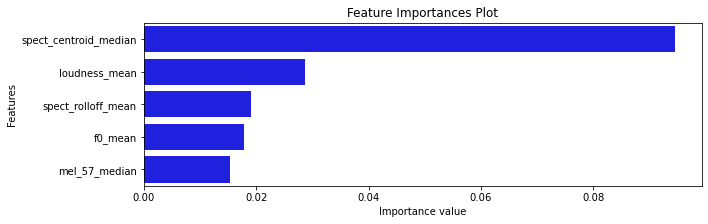

In [160]:
# in order to deduce an abstract framework of musical features impacting the induced emotion, 
# the top 5 features of the final model were considered
# Bar plot of top 5 features
plt.figure(figsize=(10,3))
sns.barplot(y='feature_names', x='feature_imp', data=feat_imp_df.iloc[:5,:], color='blue')
plt.title("Feature Importances Plot")
plt.ylabel("Features")
plt.xlabel("Importance value")
plt.show()

In [177]:
top_5_cols

['spect_centroid_median',
 'loudness_mean',
 'spect_rolloff_mean',
 'f0_mean',
 'mel_57_median']

In [182]:
# Lot of room to optimize this code as there's significant hardcoding

top_5_cols = list(feat_imp_df.feature_names[0:5])
final_df = X_valid[top_5_cols]
final_df['sound_file_class'] = y_valid

class_values = [0,1,2,3]
outcome_df = pd.DataFrame({'Emotion Class':['Q1','Q2','Q3','Q4'],
             'Description':['Happy, Surprise','Disgust, Anger, Fear','Sad','Calm']})
spect_centroid_list = []
loudness_list = []
spect_rolloff_list = []
f0_list = []
mel_list = []
for class_value in class_values:
    tmp_list = []
    class_df = final_df[final_df.sound_file_class==class_value]

    mean_val = round(np.mean(class_df.spect_centroid_median) ,2)
    min_val = round(np.min(class_df.spect_centroid_median),2) 
    max_val = round(np.max(class_df.spect_centroid_median) ,2)
    range_val = str(mean_val)+" ("+str(min_val)+" to "+ str(max_val) +" )"
    spect_centroid_list.append(range_val)

    mean_val = round(np.mean(class_df.loudness_mean) ,2)
    min_val = round(np.min(class_df.loudness_mean),2) 
    max_val = round(np.max(class_df.loudness_mean) ,2)
    range_val = str(mean_val)+" dB ("+str(min_val)+" dB to "+ str(max_val) +" dB )"
    loudness_list.append(range_val)

    mean_val = round(np.mean(class_df.spect_rolloff_mean) ,2)
    min_val = round(np.min(class_df.spect_rolloff_mean),2) 
    max_val = round(np.max(class_df.spect_rolloff_mean) ,2)
    range_val = str(mean_val)+" ("+str(min_val)+" to "+ str(max_val) +" )"
    spect_rolloff_list.append(range_val)
    
    mean_val = round(np.mean(class_df.f0_mean) ,2)
    min_val = round(np.min(class_df.f0_mean),2) 
    max_val = round(np.max(class_df.f0_mean) ,2)
    range_val = str(mean_val)+" Hz ("+str(min_val)+" Hz to "+ str(max_val) +" Hz )"
    f0_list.append(range_val)

    mean_val = round(np.mean(class_df.mel_57_median) ,2)
    mean_val = mel_to_hz(mean_val)
    
    min_val = round(np.min(class_df.mel_57_median),2) 
    min_val = mel_to_hz(min_val)
    max_val = round(np.max(class_df.mel_57_median) ,2)
    max_val = mel_to_hz(max_val)
    
    range_val = str(mean_val)+" Hz ("+str(min_val)+" Hz to "+ str(max_val) +" Hz )"
    mel_list.append(range_val)
    
    
outcome_df['Spectral Centroid Range'] = spect_centroid_list
outcome_df['Loudness Range'] = loudness_list
outcome_df['Spectral Rolloff'] = spect_rolloff_list
outcome_df['Fundamental Frequency Range'] = f0_list
outcome_df['Mel Frequency band 57 Range'] = mel_list

outcome_df.to_csv("Inference_top5_feat.csv",index = False)
outcome_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Emotion Class,Description,Spectral Centroid Range,Loudness Range,Spectral Rolloff,Fundamental Frequency Range,Mel Frequency band 57 Range
0,Q1,"Happy, Surprise",1082.34 (344.8 to 1802.19 ),-15.81 dB (-26.32 dB to -9.26 dB ),2329.39 (559.08 to 4205.72 ),286.0 Hz (164.82 Hz to 566.52 Hz ),28.0 Hz (1.33 Hz to 168.0 Hz )
1,Q2,"Disgust, Anger, Fear",1211.09 (469.91 to 1885.44 ),-12.92 dB (-23.25 dB to -7.56 dB ),2530.04 (929.92 to 3675.12 ),459.16 Hz (148.6 Hz to 963.27 Hz ),145.33 Hz (1.33 Hz to 638.0 Hz )
2,Q3,Sad,765.54 (289.43 to 1553.36 ),-17.71 dB (-30.09 dB to -9.59 dB ),1662.56 (427.32 to 3611.56 ),226.98 Hz (132.03 Hz to 495.34 Hz ),8.67 Hz (0.0 Hz to 48.67 Hz )
3,Q4,Calm,735.56 (142.58 to 1563.31 ),-17.77 dB (-28.8 dB to -10.75 dB ),1643.44 (169.49 to 3865.96 ),226.59 Hz (131.73 Hz to 466.46 Hz ),4.67 Hz (0.0 Hz to 32.67 Hz )


In [111]:
# ---------------------------- Ran till this point

['spect_centroid_median',
 'loudness_mean',
 'spect_rolloff_mean',
 'f0_mean',
 'mel_60_median',
 'power_iqr',
 'f0_median',
 'spect_contrast_median',
 'spect_rolloff_median',
 'f0_max']

Observations:
- Overall accuracy is low as the model is not able to optimally classify the classes 0 ("Q1" and "Q4"), 2 ("Q2") and 3 ("Q3")
- AdaBoost, even with lower accuracy, is a robust model as test and validation accuracies are more or less similar
- class "1", which corresponds to quadrant 2 ("Q2") in the emotion dataset represents predominantly emotions such as "Fear", "Anger", "Disgust" in the Russell's Circumplex Model of emotion. The classification report indicates that the F1-Score, Precision and Recall are high for this class. As a result, it may be concluded that the model can classify the Q2 emotions from the rest. This can be further evaluated in next steps where the whole modelling would be repeated with lesser number of classes after combining the original classes as explanied earlier.
- Box plots indicate presence of outliers in the significant & important column which needs to be treated as its presence may skew the outcome
- The box plots also offers insight into what the frequency framework of musically induced emotion would look like
- The model determines that for a "Q2" quadrant emotion to be induced, the fundamental frequency of the musical piece should be in a higher range.


Next steps:
- Implement band pass filter to cut off lower frequencies and higher frequencies - a way to eliminate outliers
- Repeat above steps with 3 classes and 2 classes to determine change in metrics & observations
- Repeat the whole process with Grandient Boosting algorithm, RandomForest, Hist Gradient Boosting and Voting classifier
- Experiment this process by extracting multiple samples of a single sound so as to have an augmented dataset 
- Expand and fine tune the freqeuncy range
- Derive a metric to measure happiness index so as to measure the probability of "Happy" emotion in a sound signal
- Determine the classification & induced emotion of sound tuned to raaga "Mayamalavagowla" along with other ragas such as "Bhairavi", "Shankarabharanam", "Todi", "Hindolam" and "Hamsadhwani"

# Formula to scale the probability values in each emotion quadrant - DO NOT DELETE

(((max(new) - min(new) ) x (probability value - max(new)/(max(old) - min(old))) + max(new)

eg.
	Orig Prob	Scaled Prob	
Q1	0.78	0.12	=(1-0)*(B5-1)/(1-0.75)+1
Q2	0.61	0.44	=(1-0)*(B6-0.75)/(0.75-0.5)+1
Q3	0.33	0.32	=(1-0)*(B7-0.5)/(0.5-0.25)+1
Q4	0.22	0.88	=(1-0)*(B8-0.25)/(0.25-0)+1


In [93]:
mel_to_hz(0)

0.0